In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import itertools
from itertools import permutations
from operator import itemgetter

In [26]:
## Load dataset
df = pd.read_csv("../../reviews_data_cleaned.csv")

In [27]:
## Convert date objects to datetime
df["at"] = pd.to_datetime(df["at"])
df["day"] = df["at"].dt.date

In [28]:
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,cleaned_reviews,day
0,gp:AOqpTOF2pFouoTzaY889tNmGv4zN9newhheNzv2-zBP...,Alex Kway,https://play-lh.googleusercontent.com/a-/AOh14...,super,5,0,5.213.1,2021-03-30 01:20:47,NaN,NaN,super,2021-03-30
1,gp:AOqpTOHLnSuiDefTW6tSLESFxMipQ_xC4lqFoqudq-V...,RL,https://play-lh.googleusercontent.com/-e1DJGr_...,They literally ask you to pay for everything. ...,1,1,5.213.1,2021-03-30 01:11:38,NaN,NaN,they liter ask you to pay for everyth you can ...,2021-03-30
2,gp:AOqpTOGtIfjFtXHRSxxzGzRCDAc_t0SRtm41FIF8x-E...,Viktoria,https://play-lh.googleusercontent.com/-vFF7--v...,I cancelled subscription on the second day aft...,1,1,NaN,2021-03-30 00:57:33,NaN,NaN,cancel subscript on second day after paid they...,2021-03-30
3,gp:AOqpTOGHg_7dUptybABL1NSUmtQL0jIOWzdGEcB0fzJ...,Tournel Henry,https://play-lh.googleusercontent.com/a-/AOh14...,A dating app that favours one gender over the ...,1,1,5.213.1,2021-03-30 00:48:36,NaN,NaN,date app that favour one gender over other in ...,2021-03-30
4,gp:AOqpTOEly8JKjN4pYT8_lqX4ogea84YEcnnuqHZtfN5...,wolf man,https://play-lh.googleusercontent.com/a-/AOh14...,If your geting notifications that you got a li...,5,1,5.213.1,2021-03-30 00:21:00,NaN,NaN,if your gete notif that you got like go to you...,2021-03-30


In [29]:
## Time scale of reviews
print(df["at"].min())
print(df["at"].max())

2015-11-29 15:15:25
2021-03-30 01:20:47


In [30]:
## Thumbs up count - important review information - comeback later to this

In [31]:
## Create a new sentiment label
## Rating 4 & 5 are 1, rest 0
df["sentiment"] = df["score"].apply(lambda x:1 if x in [4,5] else 0)

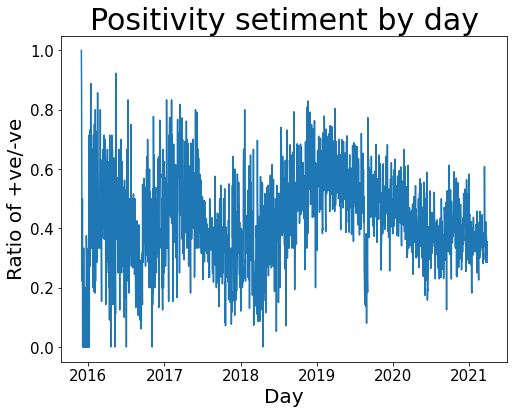

In [38]:
## Compute percentage positive reviews by day
plt.figure(figsize=(8,6))
df.groupby("day")["sentiment"].mean().plot()
plt.title("Positivity setiment by day", size=30)
plt.xlabel("Day", size=20)
plt.ylabel("Ratio of +ve/-ve", size=20)
a = plt.xticks(size=15)
b = plt.yticks(size=15)

In [40]:
## Smoother chart? -> Aggregate on monthly basis
## Have to smooth the mean over time
df["month"] = df["at"].dt.month
df["year"] = df["at"].dt.year
x = df.groupby(["year","month"],as_index=False)["sentiment"].mean().sort_values(["year","month"])
x["dummy_date"] = x.apply(lambda x:datetime(int(x["year"]), int(x["month"]),1).date(),axis=1)

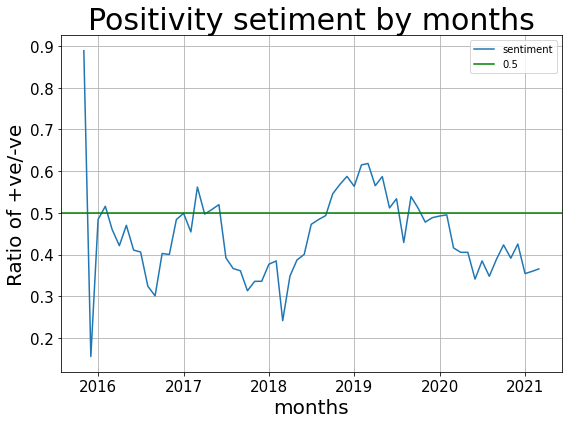

In [45]:
plt.figure(figsize=(8,6))
x.set_index("dummy_date")["sentiment"].plot()
plt.title("Positivity setiment by months", size=30)
plt.xlabel("months", size=20)
plt.ylabel("Ratio of +ve/-ve", size=20)
a = plt.xticks(size=15)
b = plt.yticks(size=15)
plt.axhline(0.5, color="green",label="0.5")
plt.legend()
plt.grid()
plt.tight_layout()

- There is some persistence/seasonality aspect of positivity ratio
- It seems that since pandemic the ratio is going down. Possible reasons?

### Exploration of number of positive reviews and negative reviews seperately

In [46]:
## Perform the date and month manipulation on the entire dataset
df["dummy_date"] = df.apply(lambda x:datetime(int(x["year"]), int(x["month"]),1).date(),axis=1)

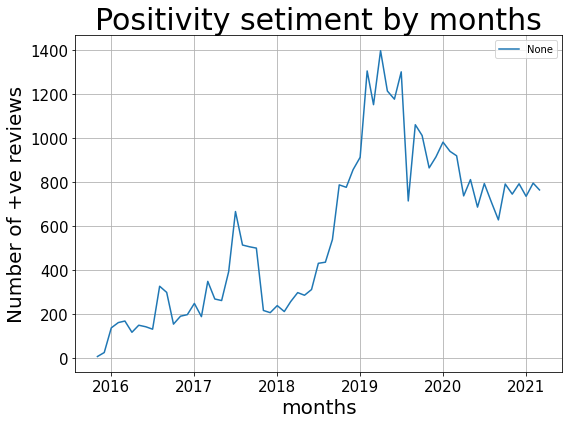

In [51]:
plt.figure(figsize=(8,6))
df[df["sentiment"]==1].groupby("dummy_date").size().plot()
plt.title("Positivity setiment by months", size=30)
plt.xlabel("months", size=20)
plt.ylabel("Number of +ve reviews", size=20)
a = plt.xticks(size=15)
b = plt.yticks(size=15)
plt.legend()
plt.grid()
plt.tight_layout()

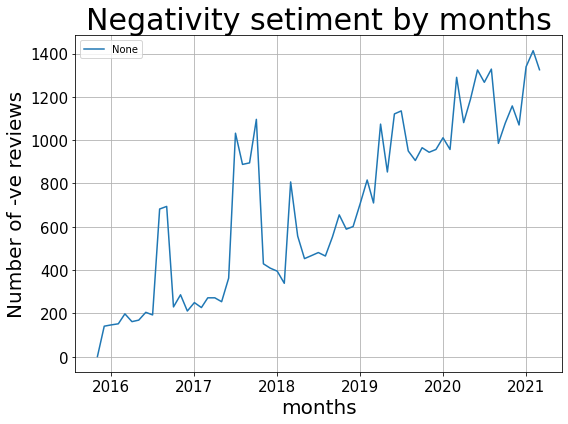

In [52]:
plt.figure(figsize=(8,6))
df[df["sentiment"]==0].groupby("dummy_date").size().plot()
plt.title("Negativity setiment by months", size=30)
plt.xlabel("months", size=20)
plt.ylabel("Number of -ve reviews", size=20)
a = plt.xticks(size=15)
b = plt.yticks(size=15)
plt.legend()
plt.grid()
plt.tight_layout()

- The number of negative reviews have a clear increasing trend

# Analysis on word frequencies
- TF-IDF of different words
- Bi-Gram/Tri-Gram freq occurances

### Keyword distribution over Time

- Can help us understand the cause for the growing negative reviews?
- Maybe also help in identifying the factors that are positive and should be focused on?

In [54]:
## Groupby year and get the top frequencies of words for both positive class and negative class
df["cleaned_reviews"].head()

0                                                super
1    they liter ask you to pay for everyth you can ...
2    cancel subscript on second day after paid they...
3    date app that favour one gender over other in ...
4    if your gete notif that you got like go to you...
Name: cleaned_reviews, dtype: object

In [60]:
## Tokenize individual reviews
stopwords_english = stopwords.words('english')
def preprocess_reviews(review, stopwords):
    # remove stopwords
    # tokenize
    review = word_tokenize(review)
    review_clean = []

    for word in review: # Go through every word in your tokens list
        if word in stopwords:  # remove stopwords
            pass
        else:
            review_clean.append(word)
    return review_clean

In [61]:
# Create a frequency table
# The nature of the frequency table would be in the form of a (word, pos) freq count
def build_freqs(reviews, sentiment):
    
    # Convert np array to list since zip needs an iterable.
    # The squeeze is necessary or the list ends up with one element.
    # Also note that this is just a NOP if ys is already a list.
    yslist = np.squeeze(sentiment).tolist()
    # Start with an empty dictionary and populate it by looping over all tweets
    # and over all processed words in each review.
    freqs = {}
    for y, review in zip(yslist, reviews):
        for word in preprocess_reviews(review, stopwords_english):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1    
    return freqs

In [81]:
## Break down the dataset by year and fetch the most frequent words
## Create a dictionary bag_word with key (date, sentiment) and value of freq dictionary
year_list = list(df["year"].unique())
year_sent_count = {}
for year in year_list:
    print("processing freq for year {}".format(year))
    poss_reviews = df[(df["year"] == year) & (df["sentiment"]==1)]["cleaned_reviews"].dropna().tolist()
    neg_reviews = df[(df["year"] == year) & (df["sentiment"]==0)]["cleaned_reviews"].dropna().tolist()
    ## concat the list
    reviews = poss_reviews + neg_reviews
    # make a numpy array representing labels of the tweets
    sentiment = np.append(np.ones((len(poss_reviews))), np.zeros((len(neg_reviews))))
    freqs = build_freqs(reviews, sentiment)
    year_sent_count[year] = freqs
    

processing freq for year 2021
processing freq for year 2020
processing freq for year 2019
processing freq for year 2018
processing freq for year 2017
processing freq for year 2016
processing freq for year 2015


In [91]:
## Get the top k words per year per sentiment
def get_top_words_year(year, k, sentiment = 1):
    year_dict = year_sent_count[year]   # Global variable used
    sentiment_dict = {}
    for key, value in year_dict.items():
        sen = key[1]
        if sen == sentiment:
            sentiment_dict[key] = value
        else:
            pass
    
    # Filter top K entries
    return sorted(sentiment_dict.items(), key=itemgetter(-1), reverse=True)[:k]

In [96]:
## Check the function
get_top_words_year(2021, 10, sentiment=1)

[(('app', 1.0), 959),
 (('good', 1.0), 544),
 (('great', 1.0), 318),
 (('date', 1.0), 314),
 (('like', 1.0), 296),
 (('peopl', 1.0), 273),
 (('use', 1.0), 202),
 (('match', 1.0), 201),
 (('nice', 1.0), 190),
 (('bumbl', 1.0), 176)]

In [97]:
## Check the function
get_top_words_year(2021, 10, sentiment=0)

[(('app', 0.0), 2505),
 (('match', 0.0), 1065),
 (('like', 0.0), 933),
 (('get', 0.0), 885),
 (('use', 0.0), 682),
 (('time', 0.0), 664),
 (('peopl', 0.0), 642),
 (('pay', 0.0), 630),
 (('even', 0.0), 600),
 (('bumbl', 0.0), 556)]

In [98]:
## Check the function
get_top_words_year(2020, 10, sentiment=1)

[(('app', 1.0), 3931),
 (('good', 1.0), 2085),
 (('great', 1.0), 1510),
 (('like', 1.0), 1236),
 (('peopl', 1.0), 1165),
 (('date', 1.0), 1120),
 (('use', 1.0), 799),
 (('match', 1.0), 771),
 (('bumbl', 1.0), 750),
 (('nice', 1.0), 704)]

In [99]:
## Check the function
get_top_words_year(2020, 10, sentiment=0)

[(('app', 0.0), 8516),
 (('match', 0.0), 3840),
 (('get', 0.0), 3253),
 (('like', 0.0), 3202),
 (('use', 0.0), 2564),
 (('pay', 0.0), 2243),
 (('time', 0.0), 2233),
 (('peopl', 0.0), 2120),
 (('swipe', 0.0), 2069),
 (('even', 0.0), 1940)]

In [101]:
### utility function for displaying df's side by side
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [106]:
### Compare top words
df_2016 = pd.DataFrame(get_top_words_year(2016,10,1))
df_2017 = pd.DataFrame(get_top_words_year(2017,10,1))
df_2018 = pd.DataFrame(get_top_words_year(2018,10,1))
df_2019 = pd.DataFrame(get_top_words_year(2019,10,1))
df_2020 = pd.DataFrame(get_top_words_year(2020,10,1))
df_2021 = pd.DataFrame(get_top_words_year(2021,10,1))

In [108]:
display_side_by_side(df_2016, df_2017, df_2018, 
                     df_2019, df_2020, df_2021, titles = ["2016","2017","2018","2019", "2020", "2021"])

,0,1
0,"(app, 1.0)",842
1,"(like, 1.0)",356
2,"(great, 1.0)",356
3,"(good, 1.0)",280
4,"(peopl, 1.0)",255
5,"(tinder, 1.0)",248
6,"(use, 1.0)",244
7,"(match, 1.0)",241
8,"(women, 1.0)",237
9,"(better, 1.0)",224


### Similarly negative words

In [109]:
### Compare top words
df_2016 = pd.DataFrame(get_top_words_year(2016,10,0))
df_2017 = pd.DataFrame(get_top_words_year(2017,10,0))
df_2018 = pd.DataFrame(get_top_words_year(2018,10,0))
df_2019 = pd.DataFrame(get_top_words_year(2019,10,0))
df_2020 = pd.DataFrame(get_top_words_year(2020,10,0))
df_2021 = pd.DataFrame(get_top_words_year(2021,10,0))

In [110]:
display_side_by_side(df_2016, df_2017, df_2018, 
                     df_2019, df_2020, df_2021, titles = ["2016","2017","2018","2019", "2020", "2021"])

,0,1
0,"(app, 0.0)",1804
1,"(match, 0.0)",1164
2,"(like, 0.0)",734
3,"(get, 0.0)",671
4,"(use, 0.0)",581
5,"(profil, 0.0)",560
6,"(peopl, 0.0)",553
7,"(messag, 0.0)",553
8,"(swipe, 0.0)",531
9,"(time, 0.0)",516


- The top 10 words is pretty consistent across years. 
- For years and positive sentiment, we have same words like app, good, great, better, nice
- For years and negative sentiment, we have same words like app, match, time, pay?
- A lot of words appear in both positive and negative sentiments - there is not much polarity in the words. Let's segregate polar words year wise

## Compute word polarity from existing database

In [130]:
def get_polar_words_year(year, k , sent=1):
    exp = year_sent_count[year]
    vocab = list(set([x[0] for x in exp.keys()]))
    new_dict = {}

    for word in vocab:
        pos_count, neg_count = exp.get((word,1),0), exp.get((word,0),0)
        new_dict[word] = np.log(pos_count+1/(neg_count+1))
    
    if sent == 1:
        reverse = True
    else:
        reverse = False
    return sorted(new_dict.items(), key=itemgetter(-1), reverse=reverse)[:k]

In [140]:
## Compare most positive words
### Compare top words
df_2016 = pd.DataFrame(get_polar_words_year(2016,20,1))
df_2017 = pd.DataFrame(get_polar_words_year(2017,20,1))
df_2018 = pd.DataFrame(get_polar_words_year(2018,20,1))
df_2019 = pd.DataFrame(get_polar_words_year(2019,20,1))
df_2020 = pd.DataFrame(get_polar_words_year(2020,20,1))
df_2021 = pd.DataFrame(get_polar_words_year(2021,20,1))

In [141]:
display_side_by_side(df_2016, df_2017, df_2018, 
                     df_2019, df_2020, df_2021, titles = ["2016","2017","2018","2019", "2020", "2021"])

,0,1
0,app,6.735781
1,great,5.874946
2,like,5.874935
3,good,5.634805
4,peopl,5.541271
5,tinder,5.513443
6,use,5.497175
7,match,5.484800
8,women,5.468070
9,better,5.411683


In [138]:
### Compare most negative polar words
df_2016 = pd.DataFrame(get_polar_words_year(2016,20,0))
df_2017 = pd.DataFrame(get_polar_words_year(2017,20,0))
df_2018 = pd.DataFrame(get_polar_words_year(2018,20,0))
df_2019 = pd.DataFrame(get_polar_words_year(2019,20,0))
df_2020 = pd.DataFrame(get_polar_words_year(2020,20,0))
df_2021 = pd.DataFrame(get_polar_words_year(2021,20,0))

In [139]:
display_side_by_side(df_2016, df_2017, df_2018, 
                     df_2019, df_2020, df_2021, titles = ["2016","2017","2018","2019", "2020", "2021"])

,0,1
0,poor,-3.496508
1,worst,-3.433987
2,told,-3.258097
3,feedback,-3.258097
4,cancel,-3.178054
5,unus,-3.135494
6,remov,-3.091042
7,everytim,-3.044522
8,fb,-2.995732
9,refus,-2.833213


- Pretty much the same conclusion with slight differences in Pos and Neg polarities
- In neg polarity, keywords like fraud, racism, sexism, discrimination , gun ?? etc words quite visible

### Hypothesis testing - Is it more likely that Bumble is rate highly by women by not so much by males ?

#### Some super basic analysis can be done. We can predict gender from Username and check this hypothesis

### Using gender guesser package

In [144]:
import gender_guesser.detector as gender

In [174]:
d = gender.Detector(case_sensitive=False)

In [175]:
##  Testing 
names = ["James", "Beth", "Kunal", "Rosie", "Paul"]
for n in names:
    print (d.get_gender(n))

male
female
unknown
female
male


In [176]:
df["userName"]

0               Alex Kway
1                      RL
2                Viktoria
3           Tournel Henry
4                wolf man
               ...       
81973          Sarah Mick
81974       Mike Mikesell
81975              Phil T
81976    Alexander Khozya
81977     Mike Kulasinski
Name: userName, Length: 81978, dtype: object

In [177]:
## Extract first name
df["first_name"] = df["userName"].apply(lambda x: x.split(' ')[0])

In [178]:
df["predicted_gender"] = df["first_name"].apply(lambda x:d.get_gender(x))

In [179]:
df["predicted_gender"].value_counts()

male             36292
unknown          26739
female           11772
mostly_male       4136
mostly_female     2114
andy               925
Name: predicted_gender, dtype: int64

In [180]:
## Visualize the names in wordcloud
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator

Text(0.5, 1.0, 'Names of male users')

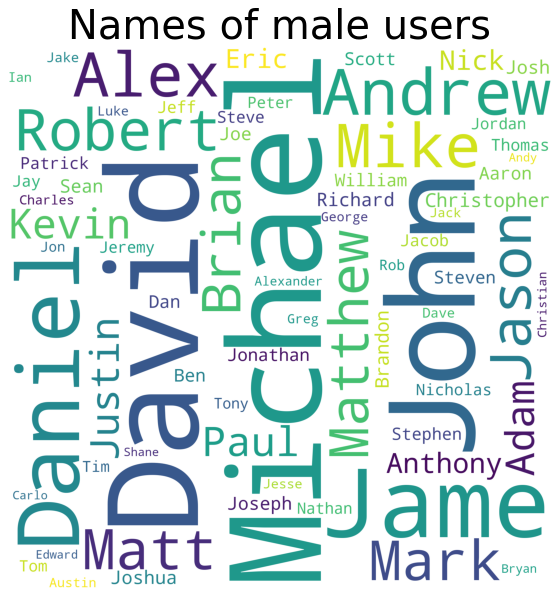

In [181]:
## Word frequency count for males
plt.figure(figsize=(10,10))
df_not_null = df[~(df["content"].isnull())]
label1 = ' '.join([text for text in df_not_null['first_name'][df_not_null['predicted_gender'] == "male"]])

wordcloud = WordCloud(background_color = 'white',width = 2000, height = 2000, max_words = 70).generate(label1)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Names of male users', fontsize = 40)

Text(0.5, 1.0, 'Names of female users')

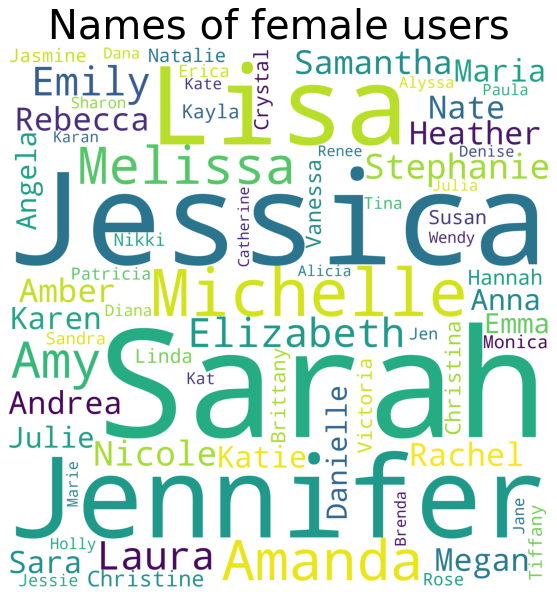

In [182]:
## Word frequency count for females
plt.figure(figsize=(10,10))
df_not_null = df[~(df["content"].isnull())]
label1 = ' '.join([text for text in df_not_null['first_name'][df_not_null['predicted_gender'] == "female"]])

wordcloud = WordCloud(background_color = 'white',width = 2000, height = 2000, max_words = 70).generate(label1)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Names of female users', fontsize = 40)

Text(0.5, 1.0, 'Names of unknown users')

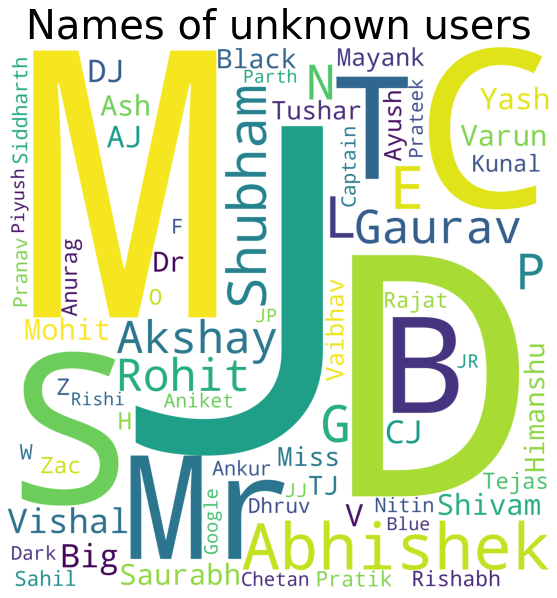

In [183]:
## Word frequency count for unknown
plt.figure(figsize=(10,10))
df_not_null = df[~(df["content"].isnull())]
label1 = ' '.join([text for text in df_not_null['first_name'][df_not_null['predicted_gender'] == "unknown"]])

wordcloud = WordCloud(background_color = 'white',width = 2000, height = 2000, max_words = 70).generate(label1)
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Names of unknown users', fontsize = 40)

#### Simplistic analysis - group genders and see response

In [198]:
## Average sentiment across male and mostly male grps vs female and mostly female grps
male = ["male", "mostly_male"]
female = ["female", "mostly_female"]
unknown = ["unknown", "andy"]

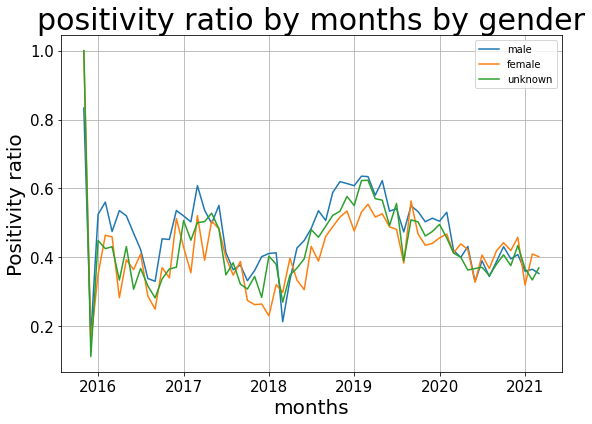

In [199]:
plt.figure(figsize=(8,6))
df[df["predicted_gender"].isin(male)].groupby("dummy_date")["sentiment"].mean().plot(label="male")
df[df["predicted_gender"].isin(female)].groupby("dummy_date")["sentiment"].mean().plot(label="female")
df[df["predicted_gender"].isin(unknown)].groupby("dummy_date")["sentiment"].mean().plot(label="unknown")
plt.title("positivity ratio by months by gender", size=30)
plt.xlabel("months", size=20)
plt.ylabel("Positivity ratio", size=20)
a = plt.xticks(size=15)
b = plt.yticks(size=15)
plt.legend()
plt.grid()
plt.tight_layout()

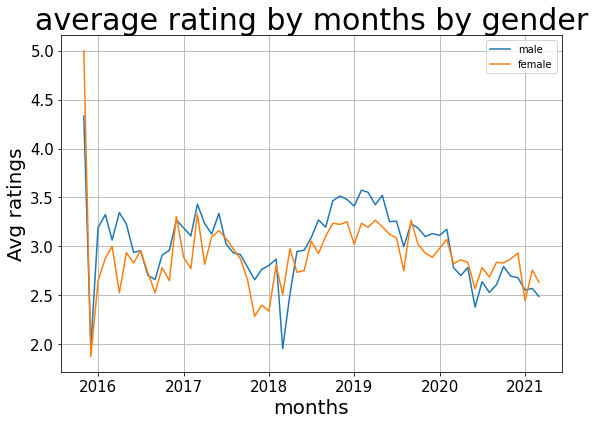

In [196]:
plt.figure(figsize=(8,6))
df[df["predicted_gender"].isin(male)].groupby("dummy_date")["score"].mean().plot(label="male")
df[df["predicted_gender"].isin(female)].groupby("dummy_date")["score"].mean().plot(label="female")
plt.title("average rating by months by gender", size=30)
plt.xlabel("months", size=20)
plt.ylabel("Avg ratings", size=20)
a = plt.xticks(size=15)
b = plt.yticks(size=15)
plt.legend()
plt.grid()
plt.tight_layout()

In [193]:
df[df["predicted_gender"].isin(female)][["score","sentiment"]].describe()

,score,sentiment
count,13886.000000,13886.000000
mean,2.912214,0.422440
std,1.616578,0.493966
min,1.000000,0.000000
25%,1.000000,0.000000
50%,3.000000,0.000000
75%,5.000000,1.000000
max,5.000000,1.000000


In [194]:
df[df["predicted_gender"].isin(male)][["score","sentiment"]].describe()

,score,sentiment
count,40428.000000,40428.000000
mean,2.980657,0.463441
std,1.703567,0.498668
min,1.000000,0.000000
25%,1.000000,0.000000
50%,3.000000,0.000000
75%,5.000000,1.000000
max,5.000000,1.000000


- This is quite interesting - women tend to down rate bumble even though it is primarily made for women

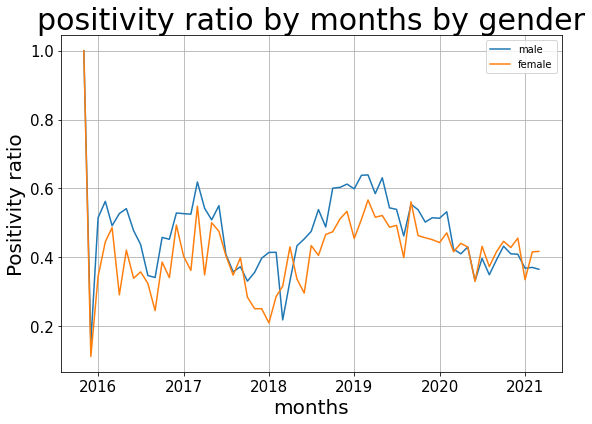

In [195]:
## Make the labels tighter and check
plt.figure(figsize=(8,6))
df[df["predicted_gender"] == "male"].groupby("dummy_date")["sentiment"].mean().plot(label="male")
df[df["predicted_gender"] == "female"].groupby("dummy_date")["sentiment"].mean().plot(label="female")
plt.title("positivity ratio by months by gender", size=30)
plt.xlabel("months", size=20)
plt.ylabel("Positivity ratio", size=20)
a = plt.xticks(size=15)
b = plt.yticks(size=15)
plt.legend()
plt.grid()
plt.tight_layout()

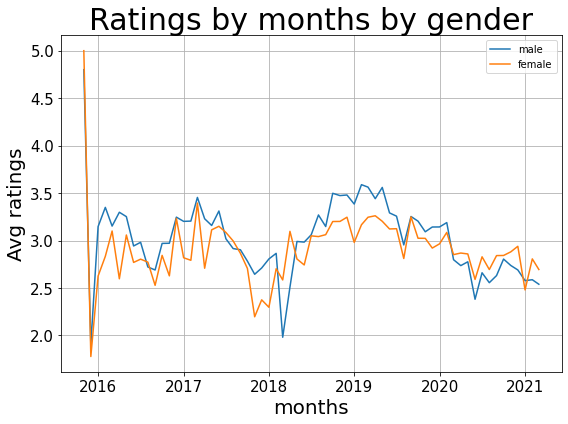

In [197]:
## Make the labels tighter and check
plt.figure(figsize=(8,6))
df[df["predicted_gender"] == "male"].groupby("dummy_date")["score"].mean().plot(label="male")
df[df["predicted_gender"] == "female"].groupby("dummy_date")["score"].mean().plot(label="female")
plt.title("Ratings by months by gender", size=30)
plt.xlabel("months", size=20)
plt.ylabel("Avg ratings", size=20)
a = plt.xticks(size=15)
b = plt.yticks(size=15)
plt.legend()
plt.grid()
plt.tight_layout()

## Word choice by men vs women

In [201]:
def pred_gender(cell):
    if cell in male:
        return "male"
    elif cell in female:
        return "female"
    else:
        return "unknown"

df["predicted_gender_overall"] = df["predicted_gender"].apply(pred_gender)

In [206]:
## Break down the dataset by year and gender fetch the most frequent words
## Create a dictionary bag_word with key (date, sentiment) and value of freq dictionary
gender_list = ["male","female","unknown"]
year_gender_sent_count = {}
for combo in itertools.product(year_list, gender_list):
    print("processing freq for year {} and gender {}".format(combo[0], combo[1]))
    year = combo[0]
    gender = combo[1]
    poss_reviews = df[(df["predicted_gender_overall"]==gender)&(df["year"] == year) & 
                      (df["sentiment"]==1)]["cleaned_reviews"].dropna().tolist()
    neg_reviews = df[(df["predicted_gender_overall"]==gender)&(df["year"] == year) & 
                     (df["sentiment"]==0)]["cleaned_reviews"].dropna().tolist()
    ## concat the list
    reviews = poss_reviews + neg_reviews
    # make a numpy array representing labels of the tweets
    sentiment = np.append(np.ones((len(poss_reviews))), np.zeros((len(neg_reviews))))
    freqs = build_freqs(reviews, sentiment)
    year_gender_sent_count[(year,gender)] = freqs

processing freq for year 2021 and gender male
processing freq for year 2021 and gender female
processing freq for year 2021 and gender unknown
processing freq for year 2020 and gender male
processing freq for year 2020 and gender female
processing freq for year 2020 and gender unknown
processing freq for year 2019 and gender male
processing freq for year 2019 and gender female
processing freq for year 2019 and gender unknown
processing freq for year 2018 and gender male
processing freq for year 2018 and gender female
processing freq for year 2018 and gender unknown
processing freq for year 2017 and gender male
processing freq for year 2017 and gender female
processing freq for year 2017 and gender unknown
processing freq for year 2016 and gender male
processing freq for year 2016 and gender female
processing freq for year 2016 and gender unknown
processing freq for year 2015 and gender male
processing freq for year 2015 and gender female
processing freq for year 2015 and gender unknown

In [209]:
def get_polar_words_year_gender(year, gender, k , sent=1):
    exp = year_gender_sent_count[(year,gender)]
    vocab = list(set([x[0] for x in exp.keys()]))
    new_dict = {}

    for word in vocab:
        pos_count, neg_count = exp.get((word,1),0), exp.get((word,0),0)
        new_dict[word] = np.log(pos_count+1/(neg_count+1))
    
    if sent == 1:
        reverse = True
    else:
        reverse = False
    return sorted(new_dict.items(), key=itemgetter(-1), reverse=reverse)[:k]

### Check top positive words by males and females

In [215]:
## Compare most positive words for males
### Compare top words for males
df_2016_m = pd.DataFrame(get_polar_words_year_gender(2016,"male", 20,1))
df_2016_f = pd.DataFrame(get_polar_words_year_gender(2016,"female", 20,1))

display_side_by_side(df_2016_m, df_2016_f, titles = ["2016 Male","2016 Female"])

,0,1
0,app,6.210602
1,great,5.303361
2,like,5.278129
3,women,5.081427
4,good,5.068958
5,tinder,5.056282
6,match,4.934485
7,use,4.897865
8,better,4.828435
9,work,4.828354


In [217]:
df_2017_m = pd.DataFrame(get_polar_words_year_gender(2017,"male", 20,1))
df_2017_f = pd.DataFrame(get_polar_words_year_gender(2017,"female", 20,1))

display_side_by_side(df_2017_m, df_2017_f, titles = ["2017 Male","2017 Female"])

,0,1
0,app,6.658012
1,great,6.084515
2,good,5.883333
3,like,5.733346
4,peopl,5.568352
5,use,5.501266
6,tinder,5.424968
7,easi,5.308409
8,better,5.278154
9,match,5.247029


In [218]:
df_2018_m = pd.DataFrame(get_polar_words_year_gender(2018,"male", 20,1))
df_2018_f = pd.DataFrame(get_polar_words_year_gender(2018,"female", 20,1))

display_side_by_side(df_2018_m, df_2018_f, titles = ["2018 Male","2018 Female"])

,0,1
0,app,6.951773
1,great,6.232462
2,good,6.202545
3,date,5.823056
4,like,5.799098
5,peopl,5.686981
6,use,5.620408
7,women,5.525463
8,tinder,5.517470
9,better,5.513459


In [220]:
df_2019_m = pd.DataFrame(get_polar_words_year_gender(2019,"male", 20,1))
df_2019_f = pd.DataFrame(get_polar_words_year_gender(2019,"female", 20,1))

display_side_by_side(df_2019_m, df_2019_f, titles = ["2019 Male","2019 Female"])

,0,1
0,app,7.687539
1,good,7.206379
2,great,7.003980
3,like,6.490725
4,date,6.463032
5,peopl,6.442542
6,use,6.118100
7,better,6.089055
8,match,5.998938
9,women,5.981419


In [224]:
df_2020_m = pd.DataFrame(get_polar_words_year_gender(2020,"male", 20,1))
df_2020_f = pd.DataFrame(get_polar_words_year_gender(2020,"female", 20,1))

display_side_by_side(df_2020_m, df_2020_f, titles = ["2020 Male","2020 Female"])

,0,1
0,app,7.542214
1,good,6.920673
2,great,6.683367
3,like,6.378427
4,date,6.304451
5,peopl,6.272879
6,match,5.926927
7,use,5.857935
8,get,5.789962
9,bumbl,5.783828


In [225]:
df_2021_m = pd.DataFrame(get_polar_words_year_gender(2021,"male", 20,1))
df_2021_f = pd.DataFrame(get_polar_words_year_gender(2021,"female", 20,1))

display_side_by_side(df_2021_m, df_2021_f, titles = ["2021 Male","2021 Female"])

,0,1
0,app,6.075348
1,good,5.488971
2,great,5.176241
3,date,5.049880
4,like,4.990446
5,peopl,4.762200
6,women,4.553930
7,match,4.532617
8,use,4.406754
9,bumbl,4.369491


In [230]:
df_2016_m = pd.DataFrame(get_polar_words_year_gender(2016,"male", 20,0))
df_2016_f = pd.DataFrame(get_polar_words_year_gender(2016,"female", 20,0))

display_side_by_side(df_2016_m, df_2016_f, titles = ["2016 Male","2016 Female"])

,0,1
0,email,-3.610918
1,useless,-3.583519
2,reinstal,-3.433987
3,gone,-3.258097
4,poor,-3.135494
5,later,-3.091042
6,liter,-2.995732
7,custom,-2.944439
8,unus,-2.944439
9,worst,-2.708050


In [231]:
df_2017_m = pd.DataFrame(get_polar_words_year_gender(2017,"male", 20,0))
df_2017_f = pd.DataFrame(get_polar_words_year_gender(2017,"female", 20,0))

display_side_by_side(df_2017_m, df_2017_f, titles = ["2017 Male","2017 Female"])

,0,1
0,useless,-4.204693
1,pointless,-3.806662
2,bother,-3.465736
3,algorithm,-3.433987
4,outsid,-3.367296
5,cancel,-3.295837
6,stuck,-3.258097
7,disappoint,-3.258097
8,refund,-3.044522
9,ignor,-2.772589


In [232]:
df_2018_m = pd.DataFrame(get_polar_words_year_gender(2018,"male", 20,0))
df_2018_f = pd.DataFrame(get_polar_words_year_gender(2018,"female", 20,0))

display_side_by_side(df_2018_m, df_2018_f, titles = ["2019 Male","2019 Female"])

,0,1
0,useless,-4.276666
1,parenthood,-3.713572
2,joke,-3.496508
3,disappoint,-3.465736
4,unabl,-3.433987
5,amend,-3.433987
6,googl,-3.433987
7,told,-3.332205
8,aw,-3.178054
9,agenda,-3.178054


In [229]:
df_2019_m = pd.DataFrame(get_polar_words_year_gender(2019,"male", 20,0))
df_2019_f = pd.DataFrame(get_polar_words_year_gender(2019,"female", 20,0))

display_side_by_side(df_2019_m, df_2019_f, titles = ["2019 Male","2019 Female"])

,0,1
0,refus,-3.850148
1,credit,-3.828641
2,password,-3.784190
3,immedi,-3.433987
4,$,-3.401197
5,violat,-3.332205
6,bank,-3.218876
7,guidelin,-3.218876
8,greedi,-3.178054
9,fraud,-3.178054


In [227]:
df_2020_m = pd.DataFrame(get_polar_words_year_gender(2020,"male", 20,0))
df_2020_f = pd.DataFrame(get_polar_words_year_gender(2020,"female", 20,0))

display_side_by_side(df_2020_m, df_2020_f, titles = ["2020 Male","2020 Female"])

,0,1
0,horribl,-4.779123
1,unsubscrib,-4.094345
2,bill,-3.988984
3,steal,-3.951244
4,racist,-3.931826
5,movement,-3.688879
6,pathet,-3.688879
7,hell,-3.663562
8,sexist,-3.637586
9,rubbish,-3.583519


In [228]:
df_2021_m = pd.DataFrame(get_polar_words_year_gender(2021,"male", 20,0))
df_2021_f = pd.DataFrame(get_polar_words_year_gender(2021,"female", 20,0))

display_side_by_side(df_2021_m, df_2021_f, titles = ["2021 Male","2021 Female"])

,0,1
0,block,-4.653960
1,email,-4.418841
2,refund,-4.060443
3,garbag,-3.988984
4,buy,-3.891820
5,trash,-3.583519
6,poor,-3.555348
7,basic,-3.465736
8,compani,-3.433987
9,ridicul,-3.332205


### Next 
- Bi-grams
- tri-grams
- Word vec association
- Topic modelling
- Word clustering